---
###  Imports & chargement

In [1]:
!pip install category-encoders
!pip install shap
!pip install xgboost
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.2 MB/s eta 0:00:00


In [2]:

import numpy as np
import pandas as pd
import warnings
import time

import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import (
    train_test_split, KFold, cross_val_score,
    RandomizedSearchCV, GridSearchCV
)
### 1. Imports & chargement
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import category_encoders as ce
import xgboost as xgb
import lightgbm as lgb
import joblib
from scipy.stats import randint, uniform

In [3]:
sns.set_theme(style='whitegrid')
plt.rcParams['font.size'] = 11
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

DATA_PATH   = '/content/drive/MyDrive/D-CLIC/projet_energisight/data/df_modeling_ready.csv'
MODEL_DIR   = '/content/drive/MyDrive/D-CLIC/projet_energisight/models/'
TARGET      = 'totalghgemissions'
TARGET_ENRG = 'siteenergyusekbtu'
SEED        = 42

df = pd.read_csv(DATA_PATH)
print(f'Dataset : {df.shape[0]} lignes x {df.shape[1]} colonnes')
print(f'Target CO2 :')
print(f'  min={df[TARGET].min():.1f}  mediane={df[TARGET].median():.1f}  max={df[TARGET].max():.0f} tonnes')
print(f'  Skew brut  : {df[TARGET].skew():.2f}')
print(f'  Skew log1p : {np.log1p(df[TARGET]).skew():.2f}')

# Correlation entre les deux targets
corr_targets = np.corrcoef(
    np.log1p(df[TARGET]),
    np.log1p(df[TARGET_ENRG])
)[0,1]
print(f'\nCorrelation log(CO2) vs log(Energie) : {corr_targets:.3f}')
print('(elevee = attendu, mais le mix energetique creera des differences)')

Dataset : 1648 lignes x 37 colonnes
Target CO2 :
  min=0.1  mediane=49.8  max=16871 tonnes
  Skew brut  : 14.14
  Skew log1p : 0.19

Correlation log(CO2) vs log(Energie) : 0.894
(elevee = attendu, mais le mix energetique creera des differences)



###  Preparation & split

In [4]:
CAT_FEATURES = [c for c in ['primarypropertytype','neighborhood',
                             'construction_era','zipcode'] if c in df.columns]
EXCLUDE      = [TARGET, TARGET_ENRG]
NUM_FEATURES = [c for c in df.select_dtypes(include=[np.number]).columns
                if c not in EXCLUDE and c not in CAT_FEATURES]

X     = df[NUM_FEATURES + CAT_FEATURES].copy()
y_raw = df[TARGET].copy()
y     = np.log1p(y_raw)   # transformation log uniquement ici

print(f'Features numeriques  : {len(NUM_FEATURES)}')
print(f'Features categorielle: {len(CAT_FEATURES)} -> {CAT_FEATURES}')
print(f'Target log1p(CO2)    : skew={y.skew():.3f}  min={y.min():.2f}  max={y.max():.2f}')

# Split stratifie sur les quartiles de y
y_bins = pd.qcut(y, q=4, labels=False)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y_bins
)
y_test_real  = np.expm1(y_test)
y_train_real = np.expm1(y_train)

print(f'\nTrain : {X_train.shape[0]} lignes  |  Test : {X_test.shape[0]} lignes')
print(f'Mediane CO2 train : {y_train_real.median():.1f} tonnes')
print(f'Mediane CO2 test  : {y_test_real.median():.1f} tonnes')

Features numeriques  : 27
Features categorielle: 4 -> ['primarypropertytype', 'neighborhood', 'construction_era', 'zipcode']
Target log1p(CO2)    : skew=0.192  min=0.11  max=9.73

Train : 1318 lignes  |  Test : 330 lignes
Mediane CO2 train : 49.8 tonnes
Mediane CO2 test  : 50.2 tonnes


---
### 3. Pipelines d'encodage

In [5]:
from sklearn.impute import SimpleImputer

ohe_preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), NUM_FEATURES),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
    ]), CAT_FEATURES),
], remainder='drop')

te_preprocessor = ColumnTransformer([
    ('num', 'passthrough', NUM_FEATURES),
    ('cat', ce.TargetEncoder(cols=CAT_FEATURES, smoothing=10, min_samples_leaf=5),
     CAT_FEATURES),
], remainder='drop')

cv_kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
print('Pipelines OHE et Target Encoding definis.')

Pipelines OHE et Target Encoding definis.


---
### 4. Utilitaires d'evaluation

In [6]:
def evaluate(pipe, name):
    y_pred_log  = pipe.predict(X_test)
    y_pred_real = np.expm1(y_pred_log)

    r2        = r2_score(y_test, y_pred_log)
    rmse_log  = np.sqrt(mean_squared_error(y_test, y_pred_log))
    mae_log   = mean_absolute_error(y_test, y_pred_log)
    rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    mape      = np.mean(np.abs((y_test_real - y_pred_real) / y_test_real.clip(lower=1))) * 100
    mdape     = np.median(np.abs((y_test_real - y_pred_real) / y_test_real.clip(lower=1))) * 100

    cv        = cross_val_score(pipe, X_train, y_train, cv=cv_kf, scoring='r2')
    overfit   = r2 - cv.mean()

    print(f'\n  [{name}]')
    print(f'    R2 test      : {r2:.4f}')
    print(f'    CV R2 5-fold : {cv.mean():.4f} +/- {cv.std():.4f}')
    print(f'    RMSE log     : {rmse_log:.4f}  |  MAE log : {mae_log:.4f}')
    print(f'    RMSE reel    : {rmse_real:.1f} tonnes')
    print(f'    MAPE         : {mape:.2f}%  |  MdAPE : {mdape:.2f}%')
    if overfit > 0.05:
        print(f'    Overfitting detecte (delta={overfit:.3f})')

    return {
        'Modele': name, 'R2 test': round(r2,4),
        'CV R2 mean': round(cv.mean(),4), 'CV R2 std': round(cv.std(),4),
        'Overfitting': round(overfit,4),
        'RMSE log': round(rmse_log,4), 'MAE log': round(mae_log,4),
        'RMSE reel (t)': round(rmse_real,1),
        'MAPE (%)': round(mape,2), 'MdAPE (%)': round(mdape,2),
    }

all_results = []
print('Utilitaires definis.')

Utilitaires definis.


---
### Entrainement des modeles

In [7]:
print('=== RIDGE & LASSO ===')
for ModelClass, name, alpha in [
    (Ridge, 'Ridge', 10.0),
    (Lasso, 'Lasso', 0.01),
]:
    pipe = Pipeline([
        ('prep',  ohe_preprocessor),
        ('impute_final', SimpleImputer(strategy='mean')),
        ('model', ModelClass(alpha=alpha))
    ])
    pipe.fit(X_train, y_train)
    all_results.append(evaluate(pipe, name))

=== RIDGE & LASSO ===


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown ca


  [Ridge]
    R2 test      : 0.9931
    CV R2 5-fold : 0.9783 +/- 0.0069
    RMSE log     : 0.1204  |  MAE log : 0.0880
    RMSE reel    : 262.6 tonnes
    MAPE         : 9.52%  |  MdAPE : 6.70%


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



  [Lasso]
    R2 test      : 0.9937
    CV R2 5-fold : 0.9806 +/- 0.0091
    RMSE log     : 0.1155  |  MAE log : 0.0728
    RMSE reel    : 372.3 tonnes
    MAPE         : 7.84%  |  MdAPE : 5.08%


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [8]:
print('=== RANDOM FOREST ===')
rf_pipe = Pipeline([
    ('prep',  te_preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=300, min_samples_leaf=3,
        max_features=0.5, n_jobs=-1, random_state=SEED
    ))
])
rf_pipe.fit(X_train, y_train)
all_results.append(evaluate(rf_pipe, 'Random Forest'))

=== RANDOM FOREST ===

  [Random Forest]
    R2 test      : 0.9904
    CV R2 5-fold : 0.9789 +/- 0.0089
    RMSE log     : 0.1426  |  MAE log : 0.0718
    RMSE reel    : 479.2 tonnes
    MAPE         : 7.60%  |  MdAPE : 3.83%


In [9]:
print('=== XGBOOST ===')
xgb_pipe = Pipeline([
    ('prep',  te_preprocessor),
    ('model', xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.1, reg_lambda=1.0,
        random_state=SEED, n_jobs=-1, verbosity=0
    ))
])
xgb_pipe.fit(X_train, y_train)
all_results.append(evaluate(xgb_pipe, 'XGBoost'))

=== XGBOOST ===

  [XGBoost]
    R2 test      : 0.9956
    CV R2 5-fold : 0.9850 +/- 0.0060
    RMSE log     : 0.0960  |  MAE log : 0.0559
    RMSE reel    : 204.9 tonnes
    MAPE         : 5.98%  |  MdAPE : 3.41%


In [10]:
print('=== LIGHTGBM ===')
lgb_pipe = Pipeline([
    ('prep',  te_preprocessor),
    ('model', lgb.LGBMRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        num_leaves=63, subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.1, reg_lambda=1.0, min_child_samples=10,
        random_state=SEED, n_jobs=-1, verbose=-1
    ))
])
lgb_pipe.fit(X_train, y_train)
all_results.append(evaluate(lgb_pipe, 'LightGBM'))

=== LIGHTGBM ===


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



  [LightGBM]
    R2 test      : 0.9953
    CV R2 5-fold : 0.9866 +/- 0.0044
    RMSE log     : 0.0990  |  MAE log : 0.0567
    RMSE reel    : 282.4 tonnes
    MAPE         : 5.91%  |  MdAPE : 3.36%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


---
###  Comparaison des modeles — score composite

=== COMPARAISON DES MODELES — PREDICTION CO2 ===


,R2 test,CV R2 mean,CV R2 std,Overfitting,RMSE log,MAE log,RMSE reel (t),MAPE (%),MdAPE (%),Rang R2,Rang MAPE,Rang MdAPE,Rang Stab,Score composite
Modele,,,,,,,,,,,,,,
Ridge,0.9931,0.9783,0.0069,0.0148,0.1204,0.0880,262.6t,9.52%,6.70%,4.000000,5.000000,5.000000,3.000000,4.25
Lasso,0.9937,0.9806,0.0091,0.0131,0.1155,0.0728,372.3t,7.84%,5.08%,3.000000,4.000000,4.000000,5.000000,4.00
Random Forest,0.9904,0.9789,0.0089,0.0114,0.1426,0.0718,479.2t,7.60%,3.83%,5.000000,3.000000,3.000000,4.000000,3.75
XGBoost,0.9956,0.9850,0.0060,0.0106,0.0960,0.0559,204.9t,5.98%,3.41%,1.000000,2.000000,2.000000,2.000000,1.75
LightGBM,0.9953,0.9866,0.0044,0.0087,0.0990,0.0567,282.4t,5.91%,3.36%,2.000000,1.000000,1.000000,1.000000,1.25



Meilleur modele (score composite) : LightGBM
  R2=0.9953  MAPE=5.91%  MdAPE=3.36%


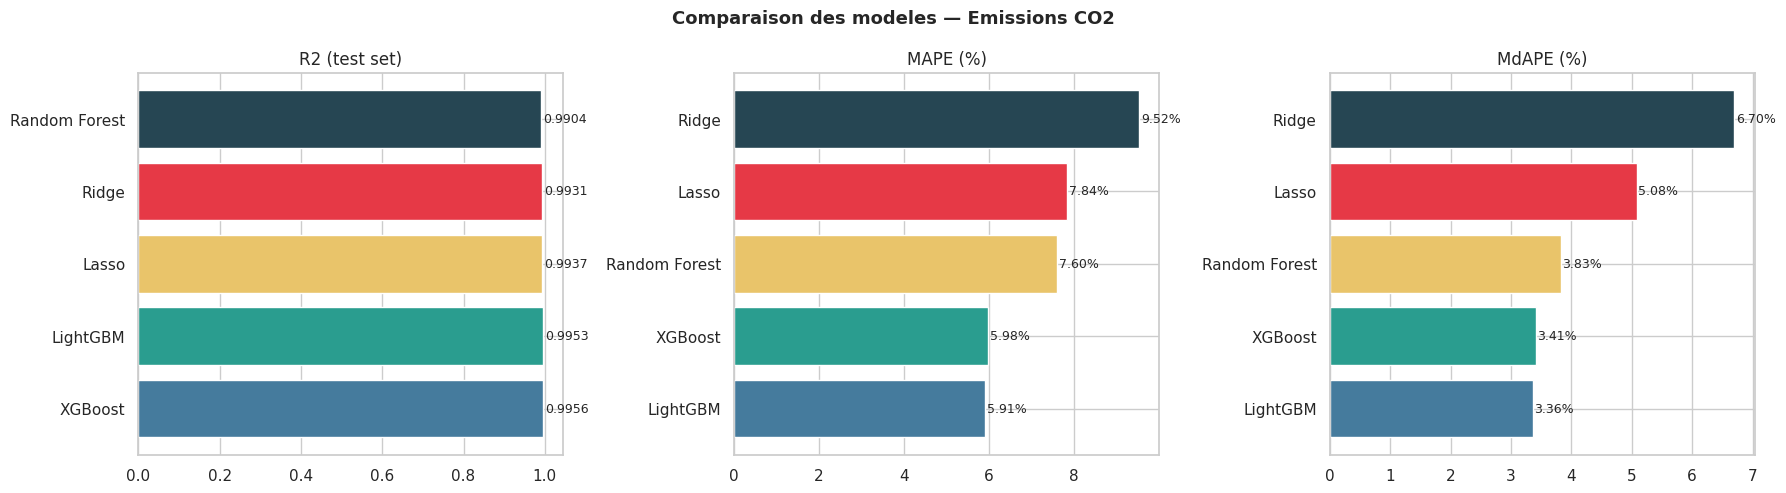

In [11]:
res_df = pd.DataFrame(all_results).set_index('Modele')

res_df['Rang R2']    = res_df['R2 test'].rank(ascending=False)
res_df['Rang MAPE']  = res_df['MAPE (%)'].rank(ascending=True)
res_df['Rang MdAPE'] = res_df['MdAPE (%)'].rank(ascending=True)
res_df['Rang Stab']  = res_df['CV R2 std'].rank(ascending=True)
res_df['Score composite'] = res_df[['Rang R2','Rang MAPE','Rang MdAPE','Rang Stab']].mean(axis=1)

print('=== COMPARAISON DES MODELES — PREDICTION CO2 ===')
display(res_df.style
    .background_gradient(cmap='RdYlGn', subset=['R2 test','CV R2 mean'], vmin=0.90, vmax=1.0)
    .background_gradient(cmap='RdYlGn_r', subset=['MAPE (%)','MdAPE (%)','Overfitting'])
    .background_gradient(cmap='RdYlGn', subset=['Score composite'], vmin=1, vmax=5)
    .format({
        'R2 test':'{:.4f}','CV R2 mean':'{:.4f}','CV R2 std':'{:.4f}',
        'Overfitting':'{:.4f}','RMSE log':'{:.4f}','MAE log':'{:.4f}',
        'RMSE reel (t)':'{:.1f}t','MAPE (%)':'{:.2f}%','MdAPE (%)':'{:.2f}%',
        'Score composite':'{:.2f}'
    })
)

best_name = res_df['Score composite'].idxmin()
best_pipe_map = {
    'Ridge': None, 'Lasso': None,
    'Random Forest': rf_pipe,
    'XGBoost': xgb_pipe,
    'LightGBM': lgb_pipe,
}
best_pipe = best_pipe_map[best_name]

print(f'\nMeilleur modele (score composite) : {best_name}')
print(f'  R2={res_df.loc[best_name,"R2 test"]:.4f}  '
      f'MAPE={res_df.loc[best_name,"MAPE (%)"]:.2f}%  '
      f'MdAPE={res_df.loc[best_name,"MdAPE (%)"]:.2f}%')

# Graphique comparatif
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Comparaison des modeles — Emissions CO2', fontsize=13, fontweight='bold')
colors = ['#457b9d','#2a9d8f','#e9c46a','#e63946','#264653']

for ax, (col, label, higher_better) in zip(axes, [
    ('R2 test',   'R2 (test set)', True),
    ('MAPE (%)',  'MAPE (%)',      False),
    ('MdAPE (%)', 'MdAPE (%)',     False),
]):
    vals = res_df[col].sort_values(ascending=not higher_better)
    bars = ax.barh(vals.index, vals.values,
                   color=[colors[i] for i in range(len(vals))])
    ax.set_title(label)
    for bar, v in zip(bars, vals.values):
        ax.text(bar.get_width()*1.005, bar.get_y()+bar.get_height()/2,
                f'{v:.4f}' if col=='R2 test' else f'{v:.2f}%',
                va='center', fontsize=9)

plt.tight_layout()
plt.show()

---
###  Analyse des residus du meilleur modele

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


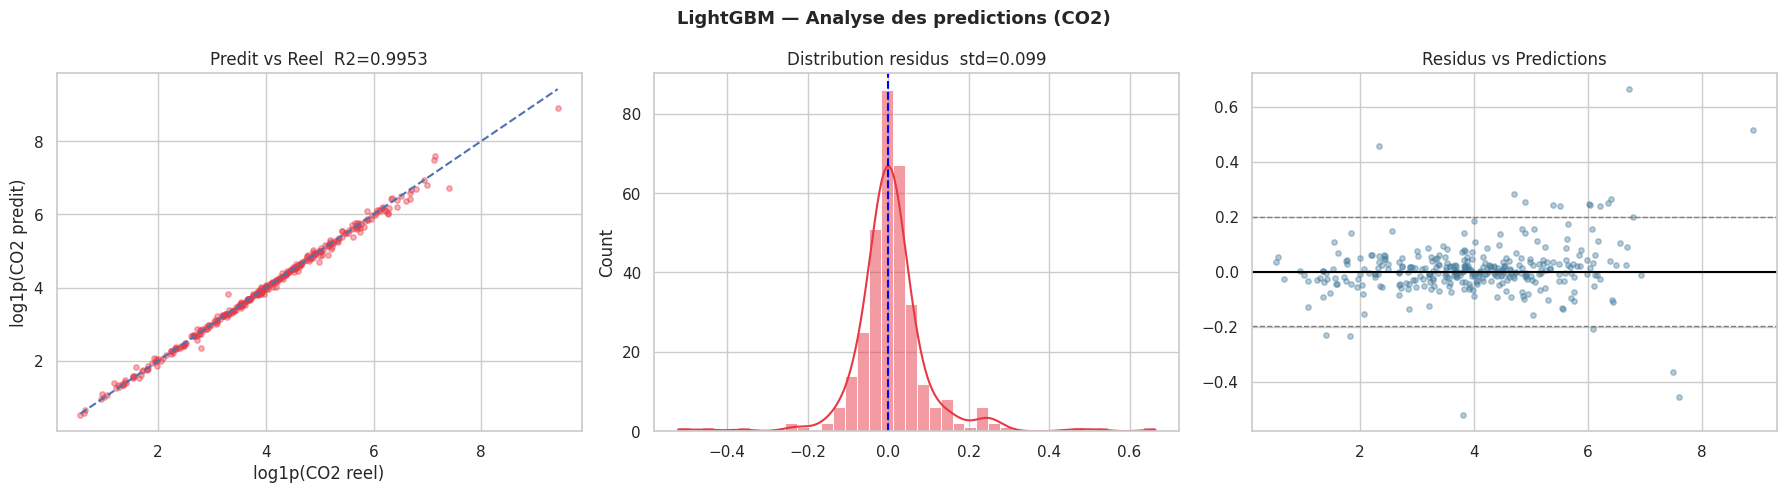

Residus — moyenne: 0.0083  std: 0.0987
% residus dans [-2sigma, +2sigma] : 94.2%


In [12]:
y_pred_log  = best_pipe.predict(X_test)
y_pred_real = np.expm1(y_pred_log)
residuals   = y_test.values - y_pred_log

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f'{best_name} — Analyse des predictions (CO2)',
             fontsize=13, fontweight='bold')

# Predit vs reel en log
axes[0].scatter(y_test, y_pred_log, alpha=0.4, s=15, color='#e63946')
lims = [y_test.min(), y_test.max()]
axes[0].plot(lims, lims, 'b--', lw=1.5)
axes[0].set_xlabel('log1p(CO2 reel)')
axes[0].set_ylabel('log1p(CO2 predit)')
axes[0].set_title(f'Predit vs Reel  R2={r2_score(y_test, y_pred_log):.4f}')

# Residus
sns.histplot(residuals, bins=40, kde=True, ax=axes[1], color='#e63946')
axes[1].axvline(0, color='blue', linestyle='--', lw=1.5)
axes[1].set_title(f'Distribution residus  std={residuals.std():.3f}')

# Residus vs predictions
axes[2].scatter(y_pred_log, residuals, alpha=0.4, s=15, color='#457b9d')
axes[2].axhline(0, color='black', lw=1.5)
axes[2].axhline( 2*residuals.std(), color='gray', linestyle='--', lw=1)
axes[2].axhline(-2*residuals.std(), color='gray', linestyle='--', lw=1)
axes[2].set_title('Residus vs Predictions')

plt.tight_layout()
plt.show()

print(f'Residus — moyenne: {residuals.mean():.4f}  std: {residuals.std():.4f}')
print(f'% residus dans [-2sigma, +2sigma] : {(np.abs(residuals) < 2*residuals.std()).mean()*100:.1f}%')

---
###  Analyse SHAP — Feature importance CO2

Point d'attention : comparer mentalement avec les SHAP du notebook énergie.
Les features `elec_ratio`, `uses_gas`, `steam_ratio` devraient
monter dans le classement par rapport au notebook energie.

SHAP calcule sur LightGBM


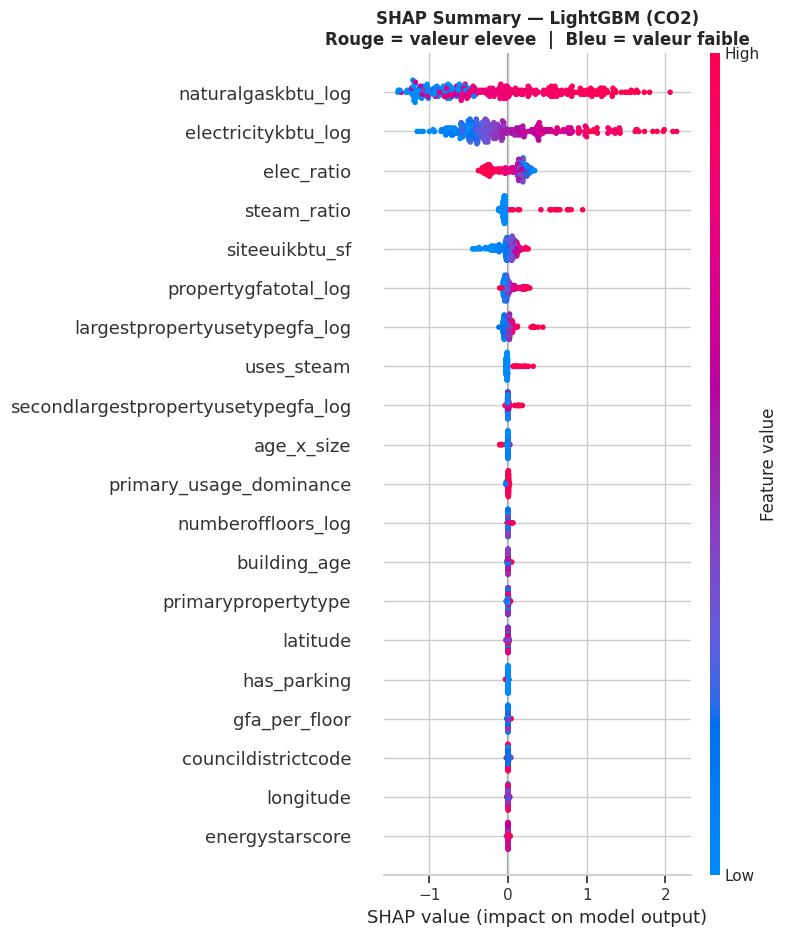

In [13]:
shap_pipe = best_pipe

X_train_t = shap_pipe.named_steps['prep'].transform(X_train)
X_test_t  = shap_pipe.named_steps['prep'].transform(X_test)

try:
    feat_names = shap_pipe.named_steps['prep'].get_feature_names_out()
    feat_names = [f.replace('num__','').replace('cat__','') for f in feat_names]
except:
    feat_names = NUM_FEATURES + CAT_FEATURES

X_test_shap = pd.DataFrame(X_test_t, columns=feat_names)

explainer   = shap.TreeExplainer(shap_pipe.named_steps['model'])
shap_values = explainer.shap_values(X_test_shap)

print(f'SHAP calcule sur {best_name}')

# Summary beeswarm
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_shap, max_display=20, plot_type='dot', show=False)
plt.title(f'SHAP Summary — {best_name} (CO2)\nRouge = valeur elevee  |  Bleu = valeur faible',
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

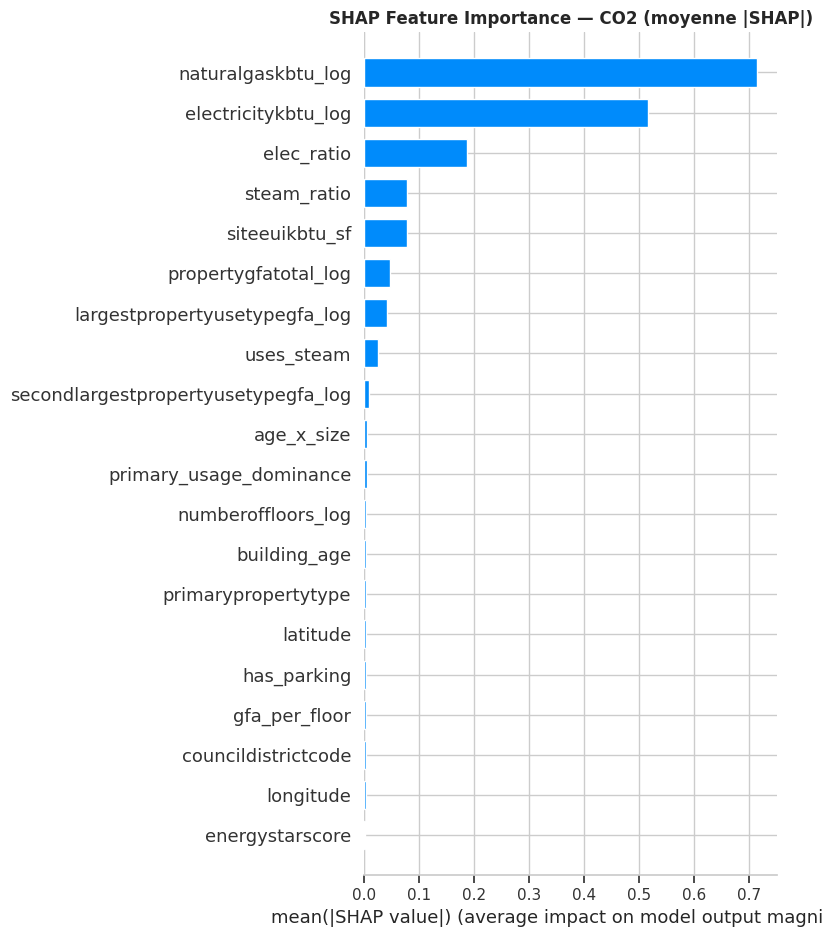


TOP 15 FEATURES — SHAP CO2 :


,Feature,Importance SHAP,Effet moyen,Direction
8,naturalgaskbtu_log,0.7145,-0.0680,Diminue CO2
9,electricitykbtu_log,0.5162,+0.0151,Augmente CO2
19,elec_ratio,0.1870,+0.0208,Augmente CO2
20,steam_ratio,0.0782,-0.0284,Diminue CO2
4,siteeuikbtu_sf,0.0775,+0.0038,Augmente CO2
10,propertygfatotal_log,0.0465,+0.0034,Augmente CO2
7,largestpropertyusetypegfa_log,0.0405,+0.0043,Augmente CO2
15,uses_steam,0.0246,-0.0064,Diminue CO2
13,secondlargestpropertyusetypegfa_log,0.0088,+0.0036,Augmente CO2
25,age_x_size,0.0052,-0.0035,Diminue CO2


In [14]:
# Bar plot SHAP
plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values, X_test_shap, max_display=20, plot_type='bar', show=False)
plt.title(f'SHAP Feature Importance — CO2 (moyenne |SHAP|)',
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Tableau recapitulatif SHAP
shap_df = pd.DataFrame({
    'Feature'               : feat_names,
    'Importance SHAP'       : np.abs(shap_values).mean(axis=0),
    'Effet moyen'           : shap_values.mean(axis=0),
}).sort_values('Importance SHAP', ascending=False).head(15)
shap_df['Direction'] = shap_df['Effet moyen'].apply(
    lambda x: 'Augmente CO2' if x > 0 else 'Diminue CO2'
)

print('\nTOP 15 FEATURES — SHAP CO2 :')
display(shap_df.style
    .background_gradient(cmap='YlOrRd', subset=['Importance SHAP'])
    .format({'Importance SHAP':'{:.4f}', 'Effet moyen':'{:+.4f}'})
)

---
###  Comparaison CO2 vs Energie — quelles features changent ?

C'est l'analyse la plus interessante du notebook.
On compare le rang SHAP de chaque feature entre les deux modeles
pour identifier ce qui est specifique aux emissions CO2.

In [15]:
# Charger les SHAP du modele energie si disponibles
# Sinon on entraine rapidement le meme modele sur la target energie
print('Calcul SHAP pour la target energie (comparaison)...')

y_energy     = np.log1p(df[TARGET_ENRG])
y_bins_e     = pd.qcut(y_energy, q=4, labels=False)
X_tr_e, X_te_e, y_tr_e, y_te_e = train_test_split(
    X, y_energy, test_size=0.20, random_state=SEED, stratify=y_bins_e
)

# Meme architecture que le meilleur modele CO2
if best_name == 'XGBoost':
    enrg_model = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        random_state=SEED, n_jobs=-1, verbosity=0
    )
else:
    enrg_model = lgb.LGBMRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        num_leaves=63, subsample=0.8, colsample_bytree=0.8,
        random_state=SEED, n_jobs=-1, verbose=-1
    )

enrg_pipe = Pipeline([('prep', te_preprocessor), ('model', enrg_model)])
enrg_pipe.fit(X_tr_e, y_tr_e)

X_te_e_t       = enrg_pipe.named_steps['prep'].transform(X_te_e)
X_te_e_shap    = pd.DataFrame(X_te_e_t, columns=feat_names)
explainer_e    = shap.TreeExplainer(enrg_pipe.named_steps['model'])
shap_values_e  = explainer_e.shap_values(X_te_e_shap)

# Comparaison des importances SHAP
shap_co2  = pd.Series(np.abs(shap_values).mean(axis=0),   index=feat_names, name='CO2')
shap_enrg = pd.Series(np.abs(shap_values_e).mean(axis=0), index=feat_names, name='Energie')

compare_df = pd.DataFrame({'CO2': shap_co2, 'Energie': shap_enrg})
compare_df['Rang CO2']    = compare_df['CO2'].rank(ascending=False).astype(int)
compare_df['Rang Energie']= compare_df['Energie'].rank(ascending=False).astype(int)
compare_df['Delta rang']  = compare_df['Rang Energie'] - compare_df['Rang CO2']
compare_df = compare_df.sort_values('CO2', ascending=False).head(20)

print('\nFeatures dont le rang change entre CO2 et Energie (|delta| > 3) :')
print('  Delta positif = feature plus importante pour CO2 que pour Energie')
print()
display(compare_df.style
    .background_gradient(cmap='RdYlGn', subset=['CO2','Energie'])
    .background_gradient(cmap='RdBu', subset=['Delta rang'], vmin=-10, vmax=10)
    .format({'CO2':'{:.4f}','Energie':'{:.4f}','Delta rang':'{:+d}'})
)

Calcul SHAP pour la target energie (comparaison)...

Features dont le rang change entre CO2 et Energie (|delta| > 3) :
  Delta positif = feature plus importante pour CO2 que pour Energie



,CO2,Energie,Rang CO2,Rang Energie,Delta rang
naturalgaskbtu_log,0.7145,0.1350,1,3,+2
electricitykbtu_log,0.5162,0.7208,2,1,-1
elec_ratio,0.1870,0.1340,3,4,+1
steam_ratio,0.0782,0.0075,4,10,+6
siteeuikbtu_sf,0.0775,0.1713,5,2,-3
propertygfatotal_log,0.0465,0.1204,6,5,-1
largestpropertyusetypegfa_log,0.0405,0.0729,7,6,-1
uses_steam,0.0246,0.0008,8,25,+17
secondlargestpropertyusetypegfa_log,0.0088,0.0120,9,7,-2
age_x_size,0.0052,0.0064,10,11,+1


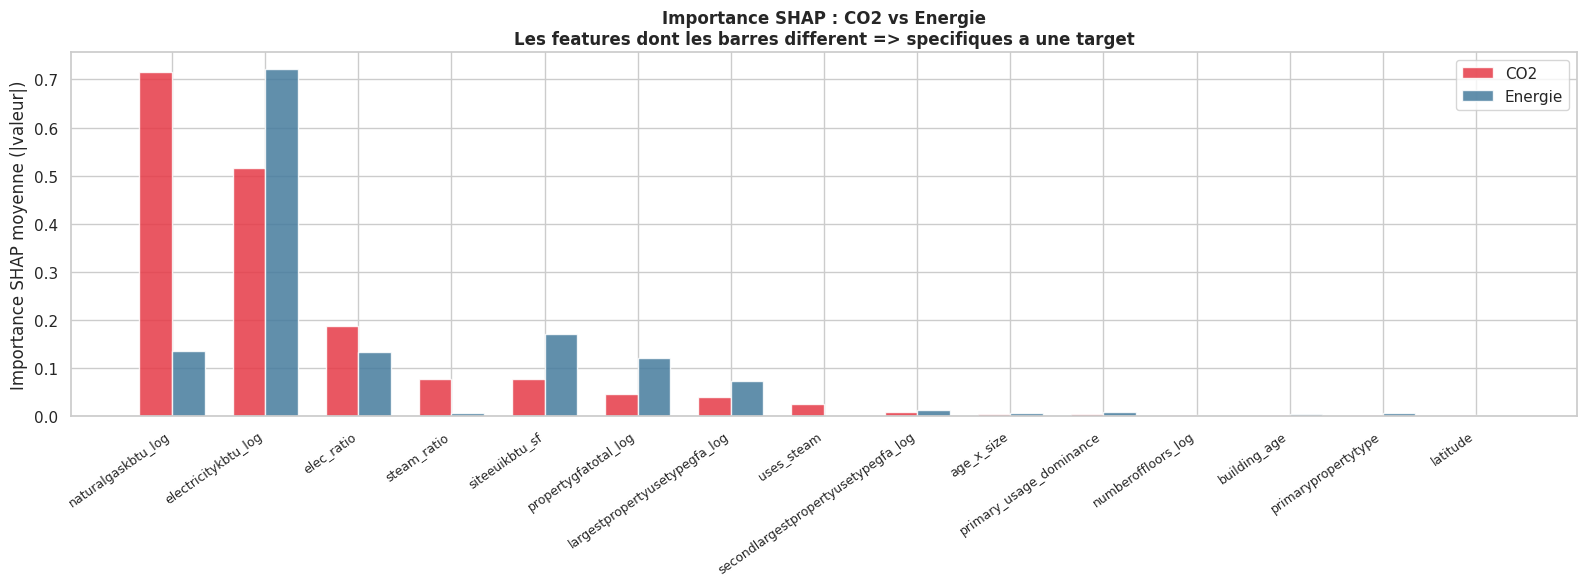


Features plus importantes pour CO2 que pour Energie (ratio > 1.5) :


,CO2,Energie,Ratio CO2/Energie
uses_steam,0.0246,0.0008,29.9243
steam_ratio,0.0782,0.0075,10.3549
naturalgaskbtu_log,0.7145,0.1350,5.2910
councildistrictcode,0.0024,0.0008,2.9832
latitude,0.0027,0.0015,1.7459


In [16]:
# Graphique comparaison CO2 vs Energie — top 15
top15 = compare_df.head(15)

x      = np.arange(len(top15))
width  = 0.35

fig, ax = plt.subplots(figsize=(16, 6))
bars1 = ax.bar(x - width/2, top15['CO2'],    width, label='CO2',    color='#e63946', alpha=0.85)
bars2 = ax.bar(x + width/2, top15['Energie'], width, label='Energie', color='#457b9d', alpha=0.85)

ax.set_xticks(x)
ax.set_xticklabels(top15.index, rotation=35, ha='right', fontsize=9)
ax.set_ylabel('Importance SHAP moyenne (|valeur|)')
ax.set_title('Importance SHAP : CO2 vs Energie\n'
             'Les features dont les barres different => specifiques a une target',
             fontsize=12, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

# Features les plus discriminantes entre les deux targets
compare_df['Ratio CO2/Energie'] = (compare_df['CO2'] + 1e-6) / (compare_df['Energie'] + 1e-6)
print('\nFeatures plus importantes pour CO2 que pour Energie (ratio > 1.5) :')
more_co2 = compare_df[compare_df['Ratio CO2/Energie'] > 1.5].sort_values('Ratio CO2/Energie', ascending=False)
if len(more_co2) > 0:
    display(more_co2[['CO2','Energie','Ratio CO2/Energie']].head(10).style
        .format('{:.4f}')
        .background_gradient(cmap='YlOrRd', subset=['Ratio CO2/Energie']))
else:
    print('Aucune feature avec ratio > 1.5 — les deux modeles utilisent des features similaires.')


---
### 10. GridSearch sur le meilleur modele

In [17]:
from sklearn.metrics import make_scorer

prefix = 'model__'

def mape_scorer_func(y_true, y_pred):
    # On est en log-espace donc on repasse en réel
    y_true_real = np.expm1(y_true)
    y_pred_real = np.expm1(y_pred)
    # Éviter la division par zéro et gérer les valeurs très petites
    return -np.mean(np.abs((y_true_real - y_pred_real) / y_true_real.clip(lower=1e-6))) # Utilisation de 1e-6 au lieu de 1
    # Négatif car sklearn maximise le score

mape_score = make_scorer(mape_scorer_func)

# Score de reference
r2_base   = r2_score(y_test, best_pipe.predict(X_test))
mape_base = np.mean(
    np.abs((y_test_real - np.expm1(best_pipe.predict(X_test))) / y_test_real.clip(lower=1))
) * 100
print(f'Score de reference : R2={r2_base:.4f}  MAPE={mape_base:.2f}%')

# ── ETAPE 1 : RandomizedSearch LEGERS (30 iterations) ────────────────────────
# On reduit n_iter de 60 a 30 — deja suffisant pour couvrir l'espace
if best_name == 'XGBoost':
    param_dist = {
        f'{prefix}n_estimators'    : randint(300, 800),
        f'{prefix}learning_rate'   : uniform(0.02, 0.10),
        f'{prefix}max_depth'       : randint(4, 8),
        f'{prefix}subsample'       : uniform(0.7, 0.3),
        f'{prefix}colsample_bytree': uniform(0.7, 0.3),
    }
else:
    param_dist = {
        f'{prefix}n_estimators'    : randint(300, 800),
        f'{prefix}learning_rate'   : uniform(0.02, 0.10),
        f'{prefix}max_depth'       : randint(4, 8),
        f'{prefix}num_leaves'      : randint(20, 100),
        f'{prefix}subsample'       : uniform(0.7, 0.3),
    }

random_search = RandomizedSearchCV(
    best_pipe, param_distributions=param_dist,
    n_iter=30,          # 30 au lieu de 60
    cv=3,               # 3-fold au lieu de 5 pour l'exploration
    scoring=mape_score,
    n_jobs=-1, verbose=0, random_state=SEED, refit=True
)
t0 = time.time()
random_search.fit(X_train, y_train)
print(f'RandomizedSearch termine en {(time.time()-t0)/60:.1f} min')
# Le score de RandomizedSearch est le MAPE négatif, donc on le transforme pour l'affichage
print(f'Meilleur CV MAPE : {-random_search.best_score_:.4f}')

# ── ETAPE 2 : GridSearch FIN sur seulement 3 parametres cles ─────────────────
# On ne gridsearche QUE les 3 parametres les plus impactants
# au lieu des 8 — ca reduit de 3^8=6561 a 3^3=27 combinaisons
bp = random_search.best_params_

if best_name == 'XGBoost':
    param_grid_fine = {
        f'{prefix}n_estimators' : [max(100, int(bp[f'{prefix}n_estimators']) - 100),
                                   int(bp[f'{prefix}n_estimators']),
                                   int(bp[f'{prefix}n_estimators']) + 100],
        f'{prefix}learning_rate': [round(bp[f'{prefix}learning_rate'] - 0.01, 3),
                                   round(bp[f'{prefix}learning_rate'], 3),
                                   round(bp[f'{prefix}learning_rate'] + 0.01, 3)],
        f'{prefix}max_depth'    : [max(3, int(bp[f'{prefix}max_depth']) - 1),
                                   int(bp[f'{prefix}max_depth']),
                                   int(bp[f'{prefix}max_depth']) + 1],
    }
else:
    param_grid_fine = {
        f'{prefix}n_estimators' : [max(100, int(bp[f'{prefix}n_estimators']) - 100),
                                   int(bp[f'{prefix}n_estimators']),
                                   int(bp[f'{prefix}n_estimators']) + 100],
        f'{prefix}learning_rate': [round(bp[f'{prefix}learning_rate'] - 0.01, 3),
                                   round(bp[f'{prefix}learning_rate'], 3),
                                   round(bp[f'{prefix}learning_rate'] + 0.01, 3)],
        f'{prefix}num_leaves'   : [max(15, int(bp[f'{prefix}num_leaves']) - 10),
                                   int(bp[f'{prefix}num_leaves']),
                                   int(bp[f'{prefix}num_leaves']) + 10],
    }

# 27 combinaisons x 5-fold = 135 entrainements — rapide
n_combos = 1
for v in param_grid_fine.values(): n_combos *= len(v)
print(f'\nGridSearch fin : {n_combos} combinaisons x 5-fold = {n_combos*5} entrainements')

grid_search = GridSearchCV(
    best_pipe, param_grid=param_grid_fine,
    cv=cv_kf, scoring=mape_score, n_jobs=-1, verbose=0, refit=True # Mise à jour pour utiliser mape_score
)
t0 = time.time()
grid_search.fit(X_train, y_train)
print(f'GridSearch fin termine en {(time.time()-t0)/60:.1f} min')
# Le score de GridSearchCV est le MAPE négatif, donc on le transforme pour l'affichage
print(f'Meilleur CV MAPE : {-grid_search.best_score_:.4f}')
for k, v in grid_search.best_params_.items():
    print(f'  {k.replace(prefix,""):<25} {v}')

Score de reference : R2=0.9953  MAPE=6.35%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


RandomizedSearch termine en 2.4 min
Meilleur CV MAPE : 0.0834

GridSearch fin : 27 combinaisons x 5-fold = 135 entrainements
GridSearch fin termine en 5.3 min
Meilleur CV MAPE : 0.0820
  learning_rate             0.035
  n_estimators              863
  num_leaves                24


=== COMPARAISON FINALE — CO2 ===


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,R2 test,CV R2 mean,CV R2 std,MAE log,RMSE reel (t),MAPE (%),MdAPE (%)
Version,,,,,,,
LightGBM Base,0.9953,—,—,0.0595,290.0t,6.35%,3.78%
LightGBM RandomizedSearch,0.9955,-0.083400,—,0.0560,279.6t,5.88%,3.47%
LightGBM GridSearch fin,0.9958,-0.082000,—,0.0528,252.1t,5.55%,3.14%



Gain R2   : +0.0005
Gain MAPE : -0.80%


/tmp/ipython-input-1567/1667512957.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(vals.index, rotation=15, ha='right', fontsize=7)
/tmp/ipython-input-1567/1667512957.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(vals.index, rotation=15, ha='right', fontsize=7)
/tmp/ipython-input-1567/1667512957.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(vals.index, rotation=15, ha='right', fontsize=7)


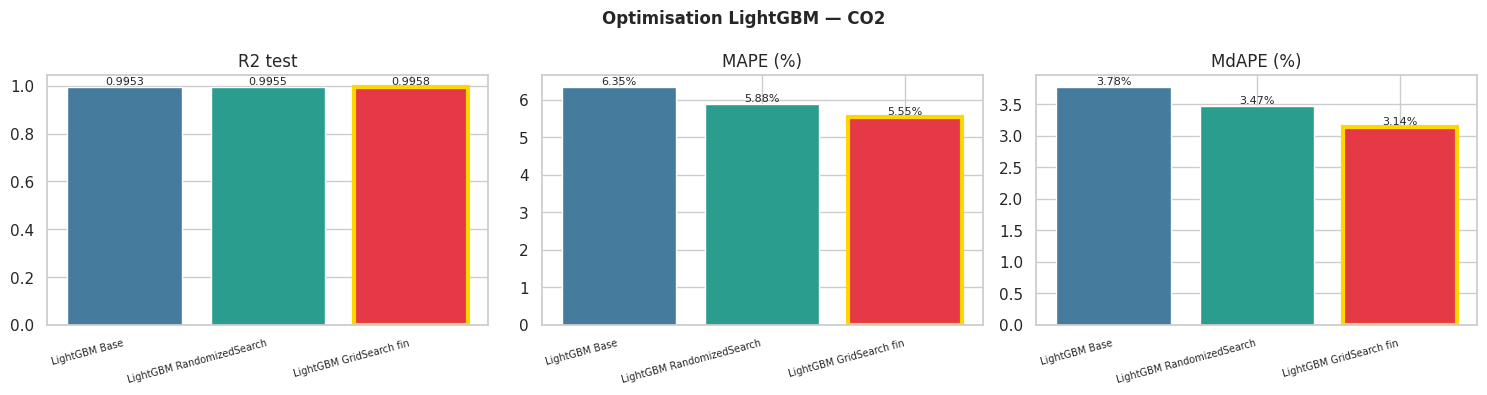

In [18]:
# Comparaison finale des 3 versions — VERSION RAPIDE
# On évite les cross_val_score redondants : les CV ont déjà été faits pendant le GridSearch

def quick_score_fast(pipe, name, cv_mean=None, cv_std=None):
    """Évalue sur le test set uniquement — pas de CV supplémentaire."""
    yp   = pipe.predict(X_test)
    ypr  = np.expm1(yp)
    r2   = r2_score(y_test, yp)
    mape = np.mean(np.abs((y_test_real-ypr)/y_test_real.clip(lower=1)))*100
    mdape= np.median(np.abs((y_test_real-ypr)/y_test_real.clip(lower=1)))*100
    mae  = mean_absolute_error(y_test, yp)
    rmse = np.sqrt(mean_squared_error(y_test_real, ypr))
    return {
        'Version'      : name,
        'R2 test'      : round(r2, 4),
        'CV R2 mean'   : round(cv_mean, 4) if cv_mean else '—',
        'CV R2 std'    : round(cv_std, 4)  if cv_std  else '—',
        'MAE log'      : round(mae, 4),
        'RMSE reel (t)': round(rmse, 1),
        'MAPE (%)'     : round(mape, 2),
        'MdAPE (%)'    : round(mdape, 2),
    }

comp = [
    # CV déjà disponibles depuis les recherches précédentes
    quick_score_fast(best_pipe,     f'{best_name} Base',
                     cv_mean=None, cv_std=None),
    quick_score_fast(random_search, f'{best_name} RandomizedSearch',
                     cv_mean=random_search.best_score_, cv_std=None),
    quick_score_fast(grid_search,   f'{best_name} GridSearch fin',
                     cv_mean=grid_search.best_score_,   cv_std=None),
]
comp_df = pd.DataFrame(comp).set_index('Version')

print('=== COMPARAISON FINALE — CO2 ===')
display(comp_df.style
    .background_gradient(cmap='RdYlGn', subset=['R2 test'], vmin=0.97, vmax=1.0)
    .background_gradient(cmap='RdYlGn_r', subset=['MAPE (%)','MdAPE (%)'])
    .format({'R2 test':'{:.4f}','MAE log':'{:.4f}',
             'RMSE reel (t)':'{:.1f}t','MAPE (%)':'{:.2f}%','MdAPE (%)':'{:.2f}%'})
)

r2_opt   = comp_df.loc[f'{best_name} GridSearch fin','R2 test']
mape_opt = comp_df.loc[f'{best_name} GridSearch fin','MAPE (%)']
print(f'\nGain R2   : {r2_opt - r2_base:+.4f}')
print(f'Gain MAPE : {mape_opt - mape_base:+.2f}%')

# Graphique identique
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle(f'Optimisation {best_name} — CO2', fontsize=12, fontweight='bold')
clrs = ['#457b9d','#2a9d8f','#e63946']
for ax, (metric, label, hi) in zip(axes, [
    ('R2 test','R2 test','max'),
    ('MAPE (%)','MAPE (%)','min'),
    ('MdAPE (%)','MdAPE (%)','min'),
]):
    vals   = comp_df[metric]
    best_v = vals.max() if hi == 'max' else vals.min()
    bars   = ax.bar(vals.index, vals.values, color=clrs)
    for bar, v in zip(bars, vals.values):
        if v == best_v: bar.set_edgecolor('gold'); bar.set_linewidth(3)
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()*1.002,
                f'{v:.4f}' if metric=='R2 test' else f'{v:.2f}%',
                ha='center', va='bottom', fontsize=8)
    ax.set_title(label)
    ax.set_xticklabels(vals.index, rotation=15, ha='right', fontsize=7)
plt.tight_layout()
plt.show()

In [19]:
import os, json
os.makedirs(MODEL_DIR, exist_ok=True)

final_model = grid_search.best_estimator_
model_path  = f'{MODEL_DIR}model_co2_{best_name.lower().replace(" ","_")}_optimized.pkl'
joblib.dump(final_model, model_path)

params_path = f'{MODEL_DIR}best_params_co2_{best_name.lower().replace(" ","_")}.json'
with open(params_path, 'w') as f:
    json.dump(grid_search.best_params_, f, indent=2)

results_path = f'{MODEL_DIR}results_co2_comparison.csv'
comp_df.to_csv(results_path)

print(f'Modèle sauvegardé dans {model_path}')

Modèle sauvegardé dans /content/drive/MyDrive/D-CLIC/projet_energisight/models/model_co2_lightgbm_optimized.pkl
